In [ ]:
# Installing PyTorch with CUDA support (matching Colab's CUDA version, usually the latest supported by PyTorch)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

# Installing Diffusers and Transformers
!pip install diffusers==0.8.0 transformers

# Installing essential and commonly used libraries
!pip install numpy pandas scipy scikit-learn matplotlib opencv-python-headless

# Additional utilities that might be useful
!pip install tqdm requests pillow

!pip install "jax[cuda12_local]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

!pip install wandb

!pip install accelerate


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-ma

In [ ]:
num_keypoints = 10
num_optimization_steps=500  # recommended higher for more complex images
batch_size=1 # recommended higher for more complex images
furthest_point_num_samples=10 # ratio of num_keypoints/furthest_point_num_samples determines the spread of kpts

image_dir = "/content/uploaded_images"

In [ ]:
from google.colab import files
import os

# Create a directory if it doesn't exist
save_dir = 'uploaded_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Upload files
uploaded = files.upload()

# Save uploaded files
for filename in uploaded.keys():
    with open(os.path.join(save_dir, filename), 'wb') as f:
        f.write(uploaded[filename])
    print(f'Saved file {filename} to {save_dir}/')

Saving output_image_0230.jpg to output_image_0230.jpg
Saving output_image_0229.jpg to output_image_0229.jpg
Saving output_image_0228.jpg to output_image_0228.jpg
Saving output_image_0227.jpg to output_image_0227.jpg
Saving output_image_0226.jpg to output_image_0226.jpg
Saving output_image_0225.jpg to output_image_0225.jpg
Saving output_image_0224.jpg to output_image_0224.jpg
Saving output_image_0223.jpg to output_image_0223.jpg
Saving output_image_0222.jpg to output_image_0222.jpg
Saving output_image_0221.jpg to output_image_0221.jpg
Saving output_image_0220.jpg to output_image_0220.jpg
Saving output_image_0219.jpg to output_image_0219.jpg
Saving output_image_0218.jpg to output_image_0218.jpg
Saving output_image_0217.jpg to output_image_0217.jpg
Saving output_image_0216.jpg to output_image_0216.jpg
Saving output_image_0215.jpg to output_image_0215.jpg
Saving output_image_0214.jpg to output_image_0214.jpg
Saving output_image_0213.jpg to output_image_0213.jpg
Saving output_image_0212.jpg

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import abc
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline, DDIMScheduler



class AttentionControl(abc.ABC):
    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return 0

    @abc.abstractmethod
    def forward(self, dict, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, dict, is_cross: bool, place_in_unet: str):

        dict = self.forward(dict, is_cross, place_in_unet)

        return dict['attn']

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class AttentionStore(AttentionControl):
    @staticmethod
    def get_empty_store():
        return {
            "attn": [],
        }

    def forward(self, dict, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        # if attn.shape[1] <= 32**2:  # avoid memory overhead
        self.step_store["attn"].append(dict['attn'])

        return dict

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()

def register_attention_control(model, controller, feature_upsample_res=256):
    def ca_forward(self, place_in_unet):
        to_out = self.to_out
        if type(to_out) is torch.nn.modules.container.ModuleList:
            to_out = self.to_out[0]
        else:
            to_out = self.to_out

        def forward(x, context=None, mask=None):
            batch_size, sequence_length, dim = x.shape
            h = self.heads
            q = self.to_q(x)
            is_cross = context is not None

            context = context if is_cross else x
            k = self.to_k(context)
            v = self.to_v(context)
            q = self.reshape_heads_to_batch_dim(q)
            k = self.reshape_heads_to_batch_dim(k)
            v = self.reshape_heads_to_batch_dim(v)

            sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale
            # sim = torch.matmul(q, k.permute(0, 2, 1)) * self.scale

            if mask is not None:
                mask = mask.reshape(batch_size, -1)
                max_neg_value = -torch.finfo(sim.dtype).max
                mask = mask[:, None, :].repeat(h, 1, 1)
                sim = sim.masked_fill(~mask, max_neg_value)

            # attention, what we cannot get enough of
            attn = torch.nn.Softmax(dim=-1)(sim)
            attn = attn.clone()

            out = torch.matmul(attn, v)

            if (
                is_cross
                and sequence_length <= 32**2
                and len(controller.step_store["attn"]) < 4
            ):
                x_reshaped = x.reshape(
                    batch_size,
                    int(sequence_length**0.5),
                    int(sequence_length**0.5),
                    dim,
                ).permute(0, 3, 1, 2)
                # upsample to feature_upsample_res**2
                x_reshaped = (
                    F.interpolate(
                        x_reshaped,
                        size=(feature_upsample_res, feature_upsample_res),
                        mode="bicubic",
                        align_corners=False,
                    )
                    .permute(0, 2, 3, 1)
                    .reshape(batch_size, -1, dim)
                )

                q = self.to_q(x_reshaped)
                q = self.reshape_heads_to_batch_dim(q)

                sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale
                attn = torch.nn.Softmax(dim=-1)(sim)
                attn = attn.clone()

                attn = controller({"attn": attn}, is_cross, place_in_unet)

            out = self.reshape_batch_dim_to_heads(out)
            return to_out(out)

        return forward

    class DummyController:
        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == "CrossAttention":
            net_.forward = ca_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, "children"):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    cross_att_count = 0
    sub_nets = model.named_children()
    for net in sub_nets:
        if "up" in net[0]:
            cross_att_count += register_recr(net[1], 0, "up")

    controller.num_att_layers = cross_att_count

    # create assertion with message
    assert cross_att_count != 0, "No cross attention layers found in the model. Please check to make sure you're using diffusers==0.8.0."

def load_ldm(device, type="CompVis/stable-diffusion-v1-4", feature_upsample_res=256):
    scheduler = DDIMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        clip_sample=False,
        set_alpha_to_one=False,
    )

    MY_TOKEN = ""
    NUM_DDIM_STEPS = 50
    scheduler.set_timesteps(NUM_DDIM_STEPS)


    ldm = StableDiffusionPipeline.from_pretrained(
        type, use_auth_token=MY_TOKEN, scheduler=scheduler
    ).to(device)

    if device != "cpu":
        ldm.unet = nn.DataParallel(ldm.unet)
        ldm.vae = nn.DataParallel(ldm.vae)

        controllers = {}
        for device_id in ldm.unet.device_ids:
            device = torch.device("cuda", device_id)
            controller = AttentionStore()
            controllers[device] = controller
    else:
        controllers = {}
        _device = torch.device("cpu")
        controller = AttentionStore()
        controllers[_device] = controller

        # patched_devices = set()

    def hook_fn(module, input):
        _device = input[0].device
        # if device not in patched_devices:
        register_attention_control(module, controllers[_device], feature_upsample_res=feature_upsample_res)
        # patched_devices.add(device)

    if device != "cpu":
        ldm.unet.module.register_forward_pre_hook(hook_fn)
    else:
        ldm.unet.register_forward_pre_hook(hook_fn)

    num_gpus = torch.cuda.device_count()

    for param in ldm.vae.parameters():
        param.requires_grad = False
    for param in ldm.text_encoder.parameters():
        param.requires_grad = False
    for param in ldm.unet.parameters():
        param.requires_grad = False

    return ldm, controllers, num_gpus


In [ ]:
ldm, controllers, num_gpus = load_ldm("cuda:0", "runwayml/stable-diffusion-v1-5", feature_upsample_res=128)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.non_ema.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

(…)fusion_pytorch_model.non_ema.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
from PIL import Image as PILImage
import os
from torchvision import transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data_root, image_size):
        super().__init__()
        self.data_root = data_root
        self.image_files = [f for f in os.listdir(data_root) if os.path.isfile(os.path.join(data_root, f))]
        # sort by name
        self.image_files.sort()
        self.transform = transforms.Compose([
            # transforms.Lambda(lambda img: img.crop((280, 0, img.width - 280, img.height))),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_root, self.image_files[idx])
        img = PILImage.open(img_path).convert('RGB')
        img = self.transform(img)
        sample = {'img': img, 'kpts': torch.zeros(15, 2), 'visibility': torch.zeros(15)}
        return sample

    def __len__(self):
        return len(self.image_files)

In [ ]:
import math


class RandomAffineWithInverse:
    def __init__(
        self,
        degrees=0,
        scale=(1.0, 1.0),
        translate=(0.0, 0.0),
    ):
        self.degrees = degrees
        self.scale = scale
        self.translate = translate

        # Initialize self.last_params to 0s
        self.last_params = {
            "theta": torch.eye(2, 3).unsqueeze(0),
        }

    def create_affine_matrix(self, angle, scale, translations_percent):
        angle_rad = math.radians(angle)

        # Create affine matrix
        theta = torch.tensor(
            [
                [math.cos(angle_rad), math.sin(angle_rad), translations_percent[0]],
                [-math.sin(angle_rad), math.cos(angle_rad), translations_percent[1]],
            ],
            dtype=torch.float,
        )

        theta[:, :2] = theta[:, :2] * scale
        theta = theta.unsqueeze(0)  # Add batch dimension
        return theta

    def __call__(self, img_tensor, theta=None):

        if theta is None:
            theta = []
            for i in range(img_tensor.shape[0]):
                # Calculate random parameters
                angle = torch.rand(1).item() * (2 * self.degrees) - self.degrees
                scale_factor = torch.rand(1).item() * (self.scale[1] - self.scale[0]) + self.scale[0]
                translations_percent = (
                    torch.rand(1).item() * (2 * self.translate[0]) - self.translate[0],
                    torch.rand(1).item() * (2 * self.translate[1]) - self.translate[1],
                    # 1.0,
                    # 1.0,
                )

                # Create the affine matrix
                theta.append(self.create_affine_matrix(
                    angle, scale_factor, translations_percent
                ))
            theta = torch.cat(theta, dim=0).to(img_tensor.device)

        # Store them for inverse transformation
        self.last_params = {
            "theta": theta,
        }

        # Apply transformation
        grid = F.affine_grid(theta, img_tensor.size(), align_corners=False).to(
            img_tensor.device
        )
        transformed_img = F.grid_sample(img_tensor, grid, align_corners=False)

        return transformed_img

    def inverse(self, img_tensor):

        # Retrieve stored parameters
        theta = self.last_params["theta"]

        # Augment the affine matrix to make it 3x3
        theta_augmented = torch.cat(
            [theta, torch.Tensor([[0, 0, 1]]).expand(theta.shape[0], -1, -1)], dim=1
        )

        # Compute the inverse of the affine matrix
        theta_inv_augmented = torch.inverse(theta_augmented)
        theta_inv = theta_inv_augmented[:, :2, :]  # Take the 2x3 part back

        # Apply inverse transformation
        grid_inv = F.affine_grid(theta_inv, img_tensor.size(), align_corners=False).to(
            img_tensor.device
        )
        untransformed_img = F.grid_sample(img_tensor, grid_inv, align_corners=False)

        return untransformed_img



def return_theta(scale, pixel_loc, rotation_angle_degrees=0):
    """
    Pixel_loc between 0 and 1
    Rotation_angle_degrees between 0 and 360
    """

    rescaled_loc = pixel_loc * 2 - 1

    rotation_angle_radians = math.radians(rotation_angle_degrees)
    cos_theta = math.cos(rotation_angle_radians)
    sin_theta = math.sin(rotation_angle_radians)

    theta = torch.tensor(
        [
            [scale * cos_theta, -scale * sin_theta, rescaled_loc[1]],
            [scale * sin_theta, scale * cos_theta, rescaled_loc[0]],
        ]
    )
    theta = theta.unsqueeze(0)
    return theta

In [ ]:
def init_random_noise(device, num_words=77):
    return torch.randn(1, num_words, 768).to(device)

def image2latent(model, image, device):
    with torch.no_grad():
        if type(image) is PILImage:
            image = np.array(image)
        if type(image) is torch.Tensor and image.dim() == 4:
            latents = image
        else:
            # print the max and min values of the image
            image = torch.from_numpy(image).float() * 2 - 1
            image = image.permute(0, 3, 1, 2).to(device)
            if device != "cpu":
                latents = model.vae.module.encode(image)["latent_dist"].mean
            else:
                latents = model.vae.encode(image)["latent_dist"].mean
            latents = latents * 0.18215
    return latents

def find_pred_noise(
    ldm,
    image,
    context,
    noise_level=-1,
    device="cuda",
):
    # if image is a torch.tensor, convert to numpy
    if type(image) == torch.Tensor:
        image = image.permute(0, 2, 3, 1).detach().cpu().numpy()

    with torch.no_grad():
        latent = image2latent(ldm, image, device)

    noise = torch.randn_like(latent)

    noisy_image = ldm.scheduler.add_noise(
        latent, noise, ldm.scheduler.timesteps[noise_level]
    )

    # import ipdb; ipdb.set_trace()

    pred_noise = ldm.unet(noisy_image,
                          ldm.scheduler.timesteps[noise_level].repeat(noisy_image.shape[0]),
                          context.repeat(noisy_image.shape[0], 1, 1))["sample"]

    return noise, pred_noise

def collect_maps(
    controller,
    from_where=["up_cross"],
    upsample_res=512,
    layers=[0, 1, 2, 3],
    indices=None,
):
    """
    returns the bilinearly upsampled attention map of size upsample_res x upsample_res for the first word in the prompt
    """

    attention_maps = controller.step_store['attn']

    attention_maps_list = []

    layer_overall = -1

    for layer in range(len(attention_maps)):
        layer_overall += 1

        if layer_overall not in layers:
            continue

        data = attention_maps[layer]

        data = data.reshape(
            data.shape[0], int(data.shape[1] ** 0.5), int(data.shape[1] ** 0.5), data.shape[2]
        )

        # import ipdb; ipdb.set_trace()

        if indices is not None:
            data = data[:, :, :, indices]

        data = data.permute(0, 3, 1, 2)

        if upsample_res != -1 and data.shape[1] ** 0.5 != upsample_res:
            # bilinearly upsample the image to attn_sizexattn_size
            data = F.interpolate(
                data,
                size=(upsample_res, upsample_res),
                mode="bilinear",
                align_corners=False,
            )

        attention_maps_list.append(data)


    attention_maps_list = torch.stack(attention_maps_list, dim=0).mean(dim=(0, 1))

    controller.reset()

    return attention_maps_list

def run_and_find_attn(
    ldm,
    image,
    context,
    noise_level=-1,
    device="cuda",
    from_where=["down_cross", "mid_cross", "up_cross"],
    layers=[0, 1, 2, 3, 4, 5],
    upsample_res=32,
    indices=None,
    controllers=None,
):
    _, _ = find_pred_noise(
        ldm,
        image,
        context,
        noise_level=noise_level,
        device=device,
    )

    attention_maps=[]

    for controller in controllers:

        _attention_maps = collect_maps(
            controllers[controller],
            from_where=from_where,
            upsample_res=upsample_res,
            layers=layers,
            indices=indices,
        )

        attention_maps.append(_attention_maps)

        controllers[controller].reset()



    return attention_maps

def gaussian_circle(pos, size=64, sigma=16, device="cuda"):
    """Create a batch of 2D Gaussian circles with a given size, standard deviation, and center coordinates.

    pos is in between 0 and 1 and has shape [batch_size, 2]

    """
    batch_size = pos.shape[0]
    _pos = pos * size  # Shape [batch_size, 2]
    _pos = _pos.unsqueeze(1).unsqueeze(1)  # Shape [batch_size, 1, 1, 2]

    grid = torch.meshgrid(torch.arange(size).to(device), torch.arange(size).to(device))
    grid = torch.stack(grid, dim=-1) + 0.5  # Shape [size, size, 2]
    grid = grid.unsqueeze(0)  # Shape [1, size, size, 2]

    dist_sq = (grid[..., 1] - _pos[..., 1]) ** 2 + (
        grid[..., 0] - _pos[..., 0]
    ) ** 2  # Shape [batch_size, size, size]
    dist_sq = -1 * dist_sq / (2.0 * sigma**2.0)
    gaussian = torch.exp(dist_sq)  # Shape [batch_size, size, size]

    return gaussian

def gaussian_circles(pos, size=64, sigma=16, device="cuda"):
    """In the case of multiple points, pos has shape [batch_size, num_points, 2]
    """

    circles = []

    for i in range(pos.shape[0]):
        _circles = gaussian_circle(
            pos[i], size=size, sigma=sigma, device=device
        )  # Assuming H and W are the same

        circles.append(_circles)

    circles = torch.stack(circles)
    circles = torch.mean(circles, dim=0)

    return circles

def find_max_pixel(map):
    """
    finds the pixel of the map with the highest value
    map shape [batch_size, h, w]

    output shape [batch_size, 2]
    """

    batch_size, h, w = map.shape

    map_reshaped = map.view(batch_size, -1)

    max_indices = torch.argmax(map_reshaped, dim=-1)

    max_indices = max_indices.view(batch_size, 1)

    max_indices = torch.cat([max_indices // w, max_indices % w], dim=-1)

    # offset by a half a pixel to get the center of the pixel
    max_indices = max_indices + 0.5

    return max_indices

def mask_radius(map, max_coords, radius):
    """
    Masks all values within a given radius of the max_coords in the map.

    Args:
    map (Tensor): The attention map with shape [batch_size, h, w].
    max_coords (Tensor): The coordinates of the point to mask around, shape [batch_size, 2].
    radius (float): The radius within which to mask the values.

    Returns:
    Tensor: The masked map.
    """
    batch_size, h, w = map.shape

    # Create a meshgrid to compute the distance for each pixel
    x_coords = torch.arange(w).view(1, -1).repeat(h, 1).to(map.device)
    y_coords = torch.arange(h).view(-1, 1).repeat(1, w).to(map.device)
    x_coords = x_coords.unsqueeze(0).repeat(batch_size, 1, 1)
    y_coords = y_coords.unsqueeze(0).repeat(batch_size, 1, 1)

    # Calculate squared Euclidean distance from the max_coords
    squared_dist = (x_coords - max_coords[:, 1].unsqueeze(1).unsqueeze(2))**2 + \
                   (y_coords - max_coords[:, 0].unsqueeze(1).unsqueeze(2))**2

    # Mask out pixels within the specified radius
    mask = squared_dist > radius**2
    masked_map = map * mask.float()

    return masked_map

def find_k_max_pixels(map, num=3):
    """
    finds the pixel of the map with the highest value
    map shape [batch_size, h, w]

    output shape [num, batch_size, 2]
    """

    batch_size, h, w = map.shape

    points = []

    for i in range(num):

        point = find_max_pixel(map)
        points.append(point)

        map = mask_radius(map, point, 0.05*h)

    return torch.stack(points)

def find_top_k_gaussian(attention_maps, top_k, sigma = 3, epsilon = 1e-5, num_subjects = 1):
    """
    attention_maps is of shape [batch_size, image_h, image_w]

    min_dist set to 0 becomes a simple top_k
    """

    device = attention_maps.device

    batch_size, image_h, image_w = attention_maps.shape

    max_pixel_locations = find_k_max_pixels(attention_maps, num=num_subjects)/image_h

    # Normalize the activation maps to represent probability distributions
    attention_maps_softmax = torch.softmax(attention_maps.view(batch_size, image_h * image_w)+epsilon, dim=-1)

    target = gaussian_circles(max_pixel_locations, size=image_h, sigma=sigma, device=attention_maps.device)

    target = target.reshape(batch_size, image_h * image_w)+epsilon
    target/=target.sum(dim=-1, keepdim=True)

    # sort the kl distances between attention_maps_softmax and target
    kl_distances = torch.sum(target * (torch.log(target) - torch.log(attention_maps_softmax)), dim=-1)
    # get the argsort for kl_distances
    kl_distances_argsort = torch.argsort(kl_distances, dim=-1, descending=False)

    return torch.tensor(kl_distances_argsort[:top_k]).to(device)

def furthest_point_sampling(attention_maps, top_k, top_initial_candidates):
    """
    attention_maps is of shape [batch_size, image_h, image_w]

    min_dist set to 0 becomes a simple top_k
    """

    device = attention_maps.device

    batch_size, image_h, image_w = attention_maps.shape

    # Assuming you have a function find_max_pixel to get the pixel locations
    max_pixel_locations = find_max_pixel(attention_maps)/image_h  # You'll need to define find_max_pixel

    # Find the furthest two points from top_initial_candidates
    max_dist = -1

    for i in range(len(top_initial_candidates)):
        for j in range(i+1, len(top_initial_candidates)):
            dist = torch.sqrt(torch.sum((max_pixel_locations[top_initial_candidates[i]] - max_pixel_locations[top_initial_candidates[j]])**2))
            if dist > max_dist:
                max_dist = dist
                furthest_pair = (top_initial_candidates[i].item(), top_initial_candidates[j].item())

    # Initialize the furthest point sampling with the furthest pair
    selected_indices = [furthest_pair[0], furthest_pair[1]]

    for _ in range(top_k - 2):
        max_min_dist = -1
        furthest_point = None

        for i in top_initial_candidates:
            if i.item() in selected_indices:
                continue

            this_min_dist = torch.min(torch.sqrt(torch.sum((max_pixel_locations[i] - torch.index_select(max_pixel_locations, 0, torch.tensor(selected_indices).to(device)))**2, dim=-1)))

            if this_min_dist > max_min_dist:
                max_min_dist = this_min_dist
                furthest_point = i.item()

        if furthest_point is not None:
            selected_indices.append(furthest_point)

    return torch.tensor(selected_indices).to(device)

def find_gaussian_loss_at_point(
    attn_map, pos, sigma=1.0, temperature=1e-1, device="cuda", indices=None, num_subjects=1
):
    """
    pos is a location between 0 and 1
    """

    # attn_map is of shape (T, H, W)
    T, H, W = attn_map.shape

    # Create Gaussian circle at the given position
    target = gaussian_circles(
        pos, size=H, sigma=sigma, device=attn_map.device
    )  # Assuming H and W are the same
    target = target.to(attn_map.device)

    # possibly select a subset of indices
    if indices is not None:
        attn_map = attn_map[indices]
        target = target[indices]

    # Compute loss
    loss = F.mse_loss(attn_map, target)

    return loss

def sharpening_loss(attn_map, sigma=1.0, temperature=1e1, device="cuda", num_subjects = 1):

    pos = find_k_max_pixels(attn_map, num=num_subjects)/attn_map.shape[-1]

    loss = find_gaussian_loss_at_point(
        attn_map,
        pos,
        sigma=sigma,
        temperature=temperature,
        device=device,
        num_subjects=num_subjects,
    )

    return loss

def equivariance_loss(embeddings_initial, embeddings_transformed, transform, index):
    # untransform the embeddings_transformed
    embeddings_initial_prime = transform.inverse(embeddings_transformed)[index]

    loss = F.mse_loss(embeddings_initial, embeddings_initial_prime)

    return loss

In [ ]:
from tqdm import tqdm
import wandb

def optimize_embedding(
    ldm,
    context=None,
    device="cuda",
    num_steps=2000,
    from_where=["down_cross", "mid_cross", "up_cross"],
    upsample_res=256,
    layers=[0, 1, 2, 3, 4, 5],
    lr=5e-3,
    noise_level=-1,
    num_tokens=1000,
    top_k=10,
    augment_degrees=30,
    augment_scale=(0.9, 1.1),
    augment_translate=(0.1, 0.1),
    dataset_loc="~",
    sigma=1.0,
    sharpening_loss_weight=100,
    equivariance_attn_loss_weight=100,
    batch_size=4,
    num_gpus=1,
    max_len=-1,
    min_dist=0.05,
    furthest_point_num_samples=50,
    controllers=None,
    validation = False,
    num_subjects=1,
):
    dataset = CustomDataset(data_root=dataset_loc, image_size=512)


    invertible_transform = RandomAffineWithInverse(
        degrees=augment_degrees,
        scale=augment_scale,
        translate=augment_translate,
    )


    # every iteration return image, pixel_loc

    if context is None:
        context = init_random_noise(device, num_words=num_tokens)

    context.requires_grad = True

    # optimize context to maximize attention at pixel_loc
    optimizer = torch.optim.Adam([context], lr=lr)

    # time the optimization
    import time

    start = time.time()

    running_equivariance_attn_loss = 0
    running_sharpening_loss = 0
    running_total_loss = 0

    # create dataloader for the dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_gpus, shuffle=True, drop_last=True)

    dataloader_iter = iter(dataloader)

    # import ipdb; ipdb.set_trace()

    for iteration in tqdm(range(int(num_steps*batch_size))):

        try:
            mini_batch = next(dataloader_iter)
        except StopIteration:  # Explicitly catch StopIteration
            dataloader_iter = iter(dataloader)
            mini_batch = next(dataloader_iter)

        image = mini_batch["img"]

        attn_maps = run_and_find_attn(
            ldm,
            image,
            context,
            layers=layers,
            noise_level=noise_level,
            from_where=from_where,
            upsample_res=-1,
            device=device,
            controllers=controllers,
        )

        # import ipdb; ipdb.set_trace()

        transformed_img = invertible_transform(image)

        attention_maps_transformed = run_and_find_attn(
            ldm,
            transformed_img,
            context,
            layers=layers,
            noise_level=noise_level,
            from_where=from_where,
            upsample_res=-1,
            device=device,
            controllers=controllers,
        )

        _sharpening_loss = []
        _loss_equivariance_attn = []

        for index, attn_map, attention_map_transformed in zip(torch.arange(num_gpus), attn_maps, attention_maps_transformed):


            top_embedding_indices = find_top_k_gaussian(
                attn_map, furthest_point_num_samples, sigma=sigma, num_subjects = num_subjects
            )

            top_embedding_indices = furthest_point_sampling(attention_map_transformed, top_k, top_embedding_indices)

            _sharpening_loss.append(sharpening_loss(attn_map[top_embedding_indices], device=device, sigma=sigma, num_subjects = num_subjects))

            _loss_equivariance_attn.append(equivariance_loss(
                attn_map[top_embedding_indices], attention_map_transformed[top_embedding_indices][None].repeat(num_gpus, 1, 1, 1), invertible_transform, index
            ))



        _sharpening_loss = torch.stack([loss.to('cuda:0') for loss in _sharpening_loss]).mean()
        _loss_equivariance_attn = torch.stack([loss.to('cuda:0') for loss in _loss_equivariance_attn]).mean()


        # use the old loss for the first 1000 iterations
        # new loss is unstable for early iterations
        loss = (
            + _loss_equivariance_attn * equivariance_attn_loss_weight
            + _sharpening_loss * sharpening_loss_weight
        )

        running_equivariance_attn_loss += _loss_equivariance_attn / (batch_size//num_gpus) * equivariance_attn_loss_weight
        running_sharpening_loss += _sharpening_loss / (batch_size//num_gpus) * sharpening_loss_weight
        running_total_loss += loss / (batch_size//num_gpus)

        loss = loss / (batch_size//num_gpus)

        loss.backward()
        if (iteration + 1) % (batch_size//num_gpus) == 0:
            optimizer.step()
            optimizer.zero_grad()
            running_equivariance_attn_loss = 0
            running_sharpening_loss = 0
            running_total_loss = 0

    print(f"optimization took {time.time() - start} seconds")

    return context.detach()

In [ ]:
embedding = optimize_embedding(
        ldm,
        num_steps=num_optimization_steps,
        batch_size=batch_size,
        top_k = num_keypoints,
        controllers=controllers,
        num_gpus=num_gpus,
        furthest_point_num_samples=furthest_point_num_samples,
        num_tokens=100,
        dataset_loc=image_dir,
    )

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-20-d782888e078d>:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(kl_distances_argsort[:top_k]).to(device)
100%|██████████| 500/500 [15:20<00:00,  1.84s/it]

optimization took 920.2602188587189 seconds


In [ ]:
@torch.no_grad()
def find_best_indices(
    ldm,
    context,
    num_steps=100,
    noise_level=-1,
    upsample_res=256,
    layers=[0, 1, 2, 3, 4, 5],
    from_where=["down_cross", "mid_cross", "up_cross"],
    top_k=10,
    dataset_loc="~",
    furthest_point_num_samples=50,
    controllers=None,
    num_gpus=1,
    sigma = 3,
    num_subjects=1,
):

    dataset = CustomDataset(data_root=dataset_loc, image_size=512)


    maps = []
    indices_list = []

    # create dataloader for the dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_gpus, shuffle=True, drop_last=True)

    dataloader_iter = iter(dataloader)

    mini_batch = dataset[0]

    for _ in tqdm(range(num_steps//num_gpus)):

        try:
            mini_batch = next(dataloader_iter)
        except StopIteration:  # Explicitly catch StopIteration
            dataloader_iter = iter(dataloader)
            mini_batch = next(dataloader_iter)

        image = mini_batch["img"]

        attention_maps = run_and_find_attn(
            ldm,
            image,
            context,
            layers=layers,
            noise_level=noise_level,
            from_where=from_where,
            upsample_res=upsample_res,
            controllers=controllers,
        )

        for attention_map in attention_maps:

            top_initial_candidates = find_top_k_gaussian(
                attention_map, furthest_point_num_samples, sigma=sigma, num_subjects = num_subjects
            )

            top_embedding_indices = furthest_point_sampling(attention_map, top_k, top_initial_candidates)

            indices_list.append(top_embedding_indices.cpu())

    # find the top_k most common indices
    indices_list = torch.cat([index for index in indices_list])
    # indices_list = indices_list.reshape(-1)
    indices, counts = torch.unique(indices_list, return_counts=True)
    indices = indices[counts.argsort(descending=True)]
    indices = indices[:top_k]

    return indices

indices = find_best_indices(
        ldm,
        embedding,
        dataset_loc=image_dir,
        controllers = controllers,
        furthest_point_num_samples=furthest_point_num_samples,
        top_k=num_keypoints,
    )

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-20-d782888e078d>:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(kl_distances_argsort[:top_k]).to(device)
100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


In [ ]:
import os
import imageio
import torch
from tqdm import tqdm
from IPython.display import HTML
from base64 import b64encode
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt

@torch.no_grad()
def run_image_with_context_augmented(
    ldm,
    image,
    context,
    indices,
    device="cuda",
    from_where=["down_cross", "mid_cross", "up_cross"],
    layers=[0, 1, 2, 3, 4, 5],
    augmentation_iterations=20,
    noise_level=-1,
    augment_degrees=30,
    augment_scale=(0.9, 1.1),
    augment_translate=(0.1, 0.1),
    controllers=None,
    num_gpus=1,
    upsample_res=512,
):
    # if image is a torch.tensor, convert to numpy
    if type(image) == torch.Tensor:
        image = image.permute(1, 2, 0).detach().cpu().numpy()

    num_samples = torch.zeros(len(indices), upsample_res, upsample_res).to(device)
    sum_samples = torch.zeros(len(indices), upsample_res, upsample_res).to(device)

    invertible_transform = RandomAffineWithInverse(
        degrees=augment_degrees,
        scale=augment_scale,
        translate=augment_translate,
    )

    for i in range(augmentation_iterations//num_gpus):

        augmented_img = (
            invertible_transform(torch.tensor(image)[None].repeat(num_gpus, 1, 1, 1).permute(0, 3, 1, 2))
            .permute(0, 2, 3, 1)
            .numpy()
        )

        attn_maps = run_and_find_attn(
            ldm,
            augmented_img,
            context,
            layers=layers,
            noise_level=noise_level,
            from_where=from_where,
            upsample_res=upsample_res,
            device=device,
            controllers=controllers,
            indices=indices.cpu(),
        )

        attn_maps = torch.stack([map.to("cuda:0") for map in attn_maps])

        _num_samples = invertible_transform.inverse(torch.ones_like(attn_maps))
        _sum_samples = invertible_transform.inverse(attn_maps)

        num_samples += _num_samples.sum(dim=0)
        sum_samples += _sum_samples.sum(dim=0)

    # visualize sum_samples/num_samples
    attention_maps = sum_samples / num_samples

    # replace all nans with 0s
    attention_maps[attention_maps != attention_maps] = 0

    return attention_maps


In [ ]:
import os
import torch
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display

# Assuming CustomDataset and other necessary modules are defined elsewhere

@torch.no_grad()
def visualize_keypoints(
    ldm,
    contexts,
    indices,
    device="cuda",
    from_where=["down_cross", "mid_cross", "up_cross"],
    layers=[0, 1, 2, 3, 4, 5],
    noise_level=-1,
    augment_degrees=30,
    augment_scale=(0.9, 1.1),
    augment_translate=(0.1, 0.1),
    augmentation_iterations=20,
    dataset_loc="~",
    controllers=None,
    num_gpus=1,
    sample_size=4  # Number of random samples
):

    dataset = CustomDataset(data_root=dataset_loc, image_size=512)

    if len(dataset) < sample_size:
        raise ValueError("sample_size larger than dataset size.")

    # Randomly sample indices from the dataset
    sampled_indices = random.sample(range(len(dataset)), sample_size)

    # Setting up the subplot
    fig, axes = plt.subplots(1, sample_size, figsize=(20, 5))

    for idx, i in enumerate(sampled_indices):

        batch = dataset[i]
        img = batch["img"]

        maps = []
        for j in range(len(contexts)):
            map = run_image_with_context_augmented(
                ldm,
                img,
                contexts[j],
                indices.cpu(),
                device=device,
                from_where=from_where,
                layers=layers,
                noise_level=noise_level,
                augment_degrees=augment_degrees,
                augment_scale=augment_scale,
                augment_translate=augment_translate,
                augmentation_iterations=augmentation_iterations,
                controllers=controllers,
                num_gpus=num_gpus,
                upsample_res=512,
            )
            maps.append(map)

        maps = torch.stack(maps)
        map = torch.mean(maps, dim=0)

        point = find_max_pixel(map) / 512.0
        point = point.unsqueeze(0).cpu()  # Prepare the point for plotting

        # Plot points on the image
        ax = axes[idx]
        ax.imshow(img.numpy().transpose(1, 2, 0))
        num_people, num_points, _ = point.shape
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        for i in range(num_people):
            for j in range(num_points):
                color = "yellow" if j == 16 else colors[j % len(colors)]
                x, y = point[i, j, 1] * 512, point[i, j, 0] * 512
                ax.scatter(x, y, color=color, marker=f"${j}$", s=300)
        ax.axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# Make sure to define or import plot_point_single, CustomDataset, and other used functions or classes.


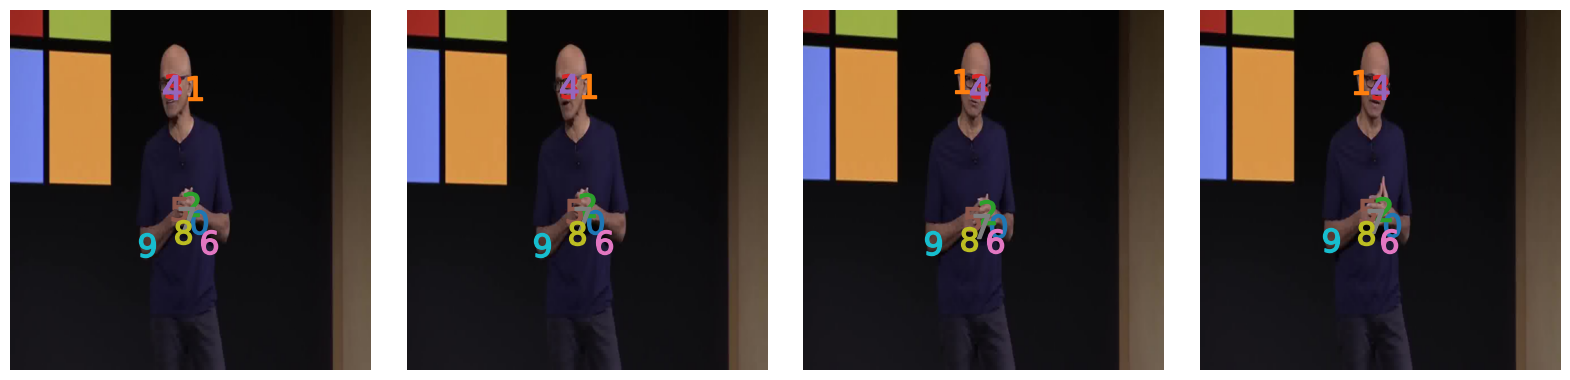

In [ ]:
visualize_keypoints(
    ldm,
    embedding,
    indices,
    dataset_loc=image_dir,
    controllers=controllers,
    augmentation_iterations=10,
)